<a href="https://colab.research.google.com/github/KaremMeza/Hydrolearn-Module-/blob/main/Sentinel_2_NDVI_T_Times_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalized Difference Vegetation Index and Thermal Band - Time Series 
# Modena

### SATELLITE: Sentinel-2 MSI: MultiSpectral Instrument, Level-2A

##  Packages

###  geemap

The geemap is a Python package for interactive mapping with Google Earth Engine (GEE), which is a cloud computing platform with a multi-petabyte catalog of satellite imagery and geospatial datasets. During the past few years, GEE has become very popular in the geospatial community and it has empowered numerous environmental applications at local, regional, and global scales. GEE provides both JavaScript and Python APIs for making computational requests to the Earth Engine servers. Compared with the comprehensive documentation and interactive IDE (i.e., GEE JavaScript Code Editor) of the GEE JavaScript API, the GEE Python API has relatively little documentation and limited functionality for visualizing results interactively. The geemap Python package was created to fill this gap. It is built upon ipyleaflet and ipywidgets, and enables users to analyze and visualize Earth Engine datasets interactively within a Jupyter-based environment (https://github.com/giswqs/geemap) .

###  eemont

The eemont package extends the Google Earth Engine Python API with pre-processing and processing tools for the most used satellite platforms by adding utility methods for different Earth Engine Objects that are friendly with the Python method chaining (https://github.com/davemlz/eemont).

###  geetools

The geetools contain functions and methods related to Google Earth Engine exclusively (https://github.com/gee-community/gee_tools)

## 1.  Install and import the following packages 

In [ ]:
 !pip install geemap
 !pip install eemont
 !pip install geetools
 !pip install -U geemap
 !pip install -U eemont

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import ee, eemont, geemap
import geemap.colormaps as cm
# import geetools for cloud /sadow discrimination
from geetools import ui, cloud_mask

## 2. Create an interactive map

In [ ]:
# Create an interactive map
Map = geemap.Map() # from ipygee

## 3. Select Irrigation Area (Pivot)

In [ ]:
# Center-pivot crops in Utah - Modena
# Coordinates:-113.816479,37.754566
# The number in buffer is the radius for the center pivot
pivot=ee.Geometry.Point([-113.816479,37.754566 ]).buffer(400)
pivot = ee.FeatureCollection([
    ee.Feature(pivot,{'pivot':0})   
])
Map.addLayer(pivot,{},'pivot')
Map.centerObject(pivot,16)
Map

## 4. Pre - process and process image collection

In [ ]:
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
     .filterBounds(pivot)
     .scaleAndOffset()
     .maskClouds()
     .filterDate('2017-04-01', '2021-07-01')
     .spectralIndices(['NDVI'])
    )

## 5. Normalized Difference Vegetation Index 

In [ ]:
collection = S2.select("NDVI")

NOTE check eemont repository for examples of maskCLouds, scale, and application of vegetation indexes. https://eemont.readthedocs.io/en/latest/guide/spectralIndices.html

## 6 Time Series  By regions 

In [ ]:
ts = S2.getTimeSeriesByRegions(collection = pivot,
                               bands = ['NDVI'],
                               reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                               scale = 10)

In [ ]:
# Conversion to Pandas
tsPandas = geemap.ee_to_pandas(ts)

In [ ]:
tsPandas

,NDVI,date,pivot,reducer
0,-9999.000000,2018-12-17T18:33:49,0,mean
1,-9999.000000,2018-12-17T18:33:48,0,mean
2,0.113087,2018-12-22T18:33:47,0,mean
3,0.098203,2018-12-22T18:33:46,0,mean
4,0.003646,2018-12-27T18:33:51,0,mean
...,...,...,...,...
729,-9999.000000,2021-06-19T18:33:55,0,median
730,-9999.000000,2021-06-19T18:33:54,0,median
731,-9999.000000,2021-06-24T18:33:55,0,median
732,0.296269,2021-06-29T18:33:57,0,median


What can we see here?

- There are some -9999 values in the NDVI column. These values represent the NA values (e.g. Clouds or shadows). The -9999 can be changed by modifying the `naValue` parameter in the `getTimeSeriesByRegion` method (e.g. `naValue = -10000`).
- Multiple reducers can be used. In the output dataframe they are specified by a single column named `reducer`: mean, median.
- The date is a string that needs to be converted to a date data type.
- The attributes of the original feature collection are attached to the data frame: `pivot`.

Given this, let's curate our data frame!

First, let's get rid of the -9999 value:

In [ ]:
tsPandas[tsPandas == -9999] = np.nan

And now, let's convert the date to a date data type:

In [ ]:
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

In [ ]:
tsPandas = pd.melt(tsPandas,
                   id_vars = ['reducer','date','pivot'],
                   value_vars = ['NDVI'],
                   var_name = 'Index',
                   value_name = 'Value')

In [ ]:
# tsPandas[tsPandas['Value'] > 1] = np.nan
tsPandas[tsPandas['Value'] < -0.5] = np.nan

tsPandas

,reducer,date,pivot,Index,Value
0,mean,2018-12-17 18:33:49,0.0,NDVI,NaN
1,mean,2018-12-17 18:33:48,0.0,NDVI,NaN
2,mean,2018-12-22 18:33:47,0.0,NDVI,0.113087
3,mean,2018-12-22 18:33:46,0.0,NDVI,0.098203
4,mean,2018-12-27 18:33:51,0.0,NDVI,0.003646
...,...,...,...,...,...
729,median,2021-06-19 18:33:55,0.0,NDVI,NaN
730,median,2021-06-19 18:33:54,0.0,NDVI,NaN
731,median,2021-06-24 18:33:55,0.0,NDVI,NaN
732,median,2021-06-29 18:33:57,0.0,NDVI,0.296269


## 7. Visualization

Now, let's visualize our time series using `seaborn`:

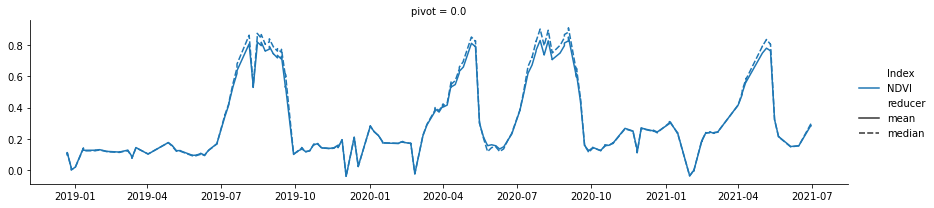

In [ ]:
g = sns.FacetGrid(tsPandas,row = 'pivot',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()